In [1]:
"""
    Notebook to explore embedding space for members and non-members for few-shot learning to see if any useful trends exist that can be utilized
    by adversary.
"""
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [47]:
import torch as ch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from distribution_inference.datasets.utils import get_dataset_wrapper
from distribution_inference.config.core import DatasetConfig, RelationConfig
from dataclasses import replace

from distribution_inference.training.utils import load_model
import distribution_inference.models.contrastive as models_contrastive
from distribution_inference.attacks.blackbox.utils import get_relation_preds
from tqdm import tqdm
import torchvision.transforms as transforms

# Set DPI to 300 for better quality
plt.rcParams['figure.dpi'] = 300

In [4]:
@ch.no_grad()
def collect_embeddings(model, loader):
    """
        Collect embeddings for a given model and loader
    """
    embeddings, labels = [], []
    for batch in tqdm(loader, desc="Collecting embeddings"):
        embed = model(batch[0].cuda(), embedding_mode=True).detach().cpu().numpy()
        embeddings.append(embed)
        labels.append(batch[1].numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    # Flatten out embeddings:
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [5]:
def look_at_metrics(embeds):
    centroid = np.mean(embeds, axis=0)
    # Distances from all points to centroid
    dists = np.linalg.norm(embeds - centroid, axis=1).mean()
    # Distances from all points to each other
    dists2 = np.linalg.norm(embeds[:, None] - embeds[None, :], axis=2).mean()
    return dists, dists2

In [6]:
def experiment(ds_adv, ds_victim,
               victim_model_path: str,
               batch_size: int = 128,
               n_people: int = 5,
               skip_plot: bool = False):
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Collect embeddings
    member_embeds, member_labels = collect_embeddings(victim_model, loader_members)
    nonmember_embeds, nonmember_labels = collect_embeddings(victim_model, loader_nonmembers)

    # Pick n_people random people from nonmember_labels
    random_nonmembers = np.random.choice(np.unique(nonmember_labels), size=n_people, replace=False)
    # Keep only embeddings for these people
    nonmember_embeds = nonmember_embeds[np.isin(nonmember_labels, random_nonmembers)]
    nonmember_labels = nonmember_labels[np.isin(nonmember_labels, random_nonmembers)]

    # Gather some metrics
    member_metrics = np.array([look_at_metrics(member_embeds[member_labels == i]) for i in np.unique(member_labels)])
    nonmember_metrics = np.array([look_at_metrics(nonmember_embeds[nonmember_labels == i]) for i in np.unique(nonmember_labels)])

    if skip_plot:
        return member_metrics, nonmember_metrics

    # Create colors array such that each person has a unique color
    unique_colors = np.unique(np.concatenate([member_labels, nonmember_labels]))
    num_colors = len(unique_colors)
    # Create colormap
    cmap = plt.cm.get_cmap('tab10', num_colors)
    # Create color array
    member_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in member_labels]
    nonmember_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in nonmember_labels]

    # Combine embeddings
    embeds = np.concatenate([member_embeds, nonmember_embeds], axis=0)

    # Get t-SNE embeddings
    tsne = TSNE(n_components=2, random_state=2023)
    tsne_embeds = tsne.fit_transform(embeds)

    # Plot member-corresponding data with marker as 'x'
    plt.scatter(tsne_embeds[:len(member_labels), 0], tsne_embeds[:len(member_labels), 1], c=member_labels, marker='x', cmap='tab10')
    # Plot nonmember-corresponding data with marker as 'o'
    plt.scatter(tsne_embeds[len(member_labels):, 0], tsne_embeds[len(member_labels):, 1], c=nonmember_labels, marker='o', cmap='tab10')

    plt.show()

    return member_metrics, nonmember_metrics

In [109]:
def relational_experiment(ds_adv, ds_victim,
                          victim_model_path: str,
                          batch_size: int = 128,
                          n_people: int = 5,
                          n_support: int = 5,
                          n_way: int = 5,
                          skip_plot: bool = False,
                          collect_ind: bool = False):
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(
        victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)
    
    # Set up a transforms pipeline with augmentations, will be used to study "variance" of model scores
    transform = transforms.Compose([
        transforms.RandomAffine(degrees=0,
                                translate=(0.02, 0.02)),
        transforms.Normalize((0.5), (0.5))
    ])

    def _collect_matching(loader):
        mapping = {}
        for batch in loader:
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    # def _treatment(map):
    #     relation_vals = []
    #     for k, v in tqdm(map.items(), desc="Collecting relation values"):
    #         embeds_person = victim_model(v.cuda(), embedding_mode=True).detach()
    #         # Look at nC2 pairs of distances in embedding space
    #         relations = []
    #         for i in range(len(embeds_person)):
    #             for j in range(i+1, len(embeds_person)):
    #                 relations.append(ch.norm(embeds_person[i] - embeds_person[j]).item())
    #         # Use average in this distance
    #         relation_vals.append(np.mean(relations))

    #     return np.array(relation_vals)

    def _treatment(map):
        relation_vals = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            # Temoprary: pick 5 random images for given person, look at nC2 relation values
            # embeds_person = victim_model(v.cuda(), embedding_mode=True).detach()
            # Use first n_support images as support
        #     support = ch.mean(embeds_person[:n_support], 0).unsqueeze(0)
        #     # Use last n_support images as query
        #     query = embeds_person[n_support:]
        #     # Apply transform
        #     query_to_img = (query + 1) / 2
        #     query = transform(query_to_img)
        #     query = query.cuda()
        #     # 1, 64, ?, ? and n, 64, ?, ?
        #     support_ = support.repeat(query.shape[0], 1, 1, 1)
        #     combined = ch.cat((support_, query), 1)
        #     relations = victim_model(combined, embedding_mode=False).detach().cpu().numpy()
        #     relation_vals.append([np.max(relations) - np.min(relations), np.mean(relations)])
        # return np.array(relation_vals)

            # Pick n_way - 1 other people randomly from map.keys()
            other_people = np.random.choice(list(map.keys()), size=n_way - 1, replace=False)
            this_images = v
            # Pick first n_support images from this_images
            if collect_ind:
                support_images = [x.unsqueeze(0).cuda() for x in this_images[:n_support]]
            else:
                support_images = [this_images[:n_support].cuda()]
            for o in other_people:
                random_choice = np.random.choice(len(map[o]), size=n_support, replace=False)
                # Randomly n_support from map[o]
                support = map[o][random_choice]
                if collect_ind:
                    for x in support:
                        support_images.append(x.unsqueeze(0).cuda())
                else:
                    support_images.append(support.cuda())
            query_images = this_images[n_support:].cuda()
            # print([x.shape for x in support_images])
            relation_values = get_relation_preds(support_images, query_images, [victim_model], verbose=False)
            if collect_ind:
                wanted_relation_values = relation_values[:, :n_support]
            else:
                wanted_relation_values = relation_values[:, 0]
            relation_vals.extend(wanted_relation_values.cpu().detach().numpy())
        return np.array(relation_vals)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [104]:
model_paths = [
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/1_0.90.ch",
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/2_0.90.ch",
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/3_0.89.ch"
]

rel_config  = RelationConfig(n_way=5, k_shot=5, num_query_train=5, num_query_test=5, test_num_task=80)
base_config = DatasetConfig(name="celeba_person", prop=1, classify=None,
                            split="victim", value=False, augment=False, relation_config=rel_config)
adv_config = replace(base_config, split="adv")

# Get dataset wrapper
ds_wrapper_class = get_dataset_wrapper("celeba_person")


# Create DS objects
ds_vic = ds_wrapper_class(base_config)
ds_adv = ds_wrapper_class(adv_config)

In [128]:
index = 2
mem, nonmem = relational_experiment(
    ds_adv, ds_vic, model_paths[index], n_people=50, collect_ind=True)

In [121]:
mem, nonmem = experiment(ds_adv, ds_vic, model_paths[index], n_people=50, skip_plot=True)

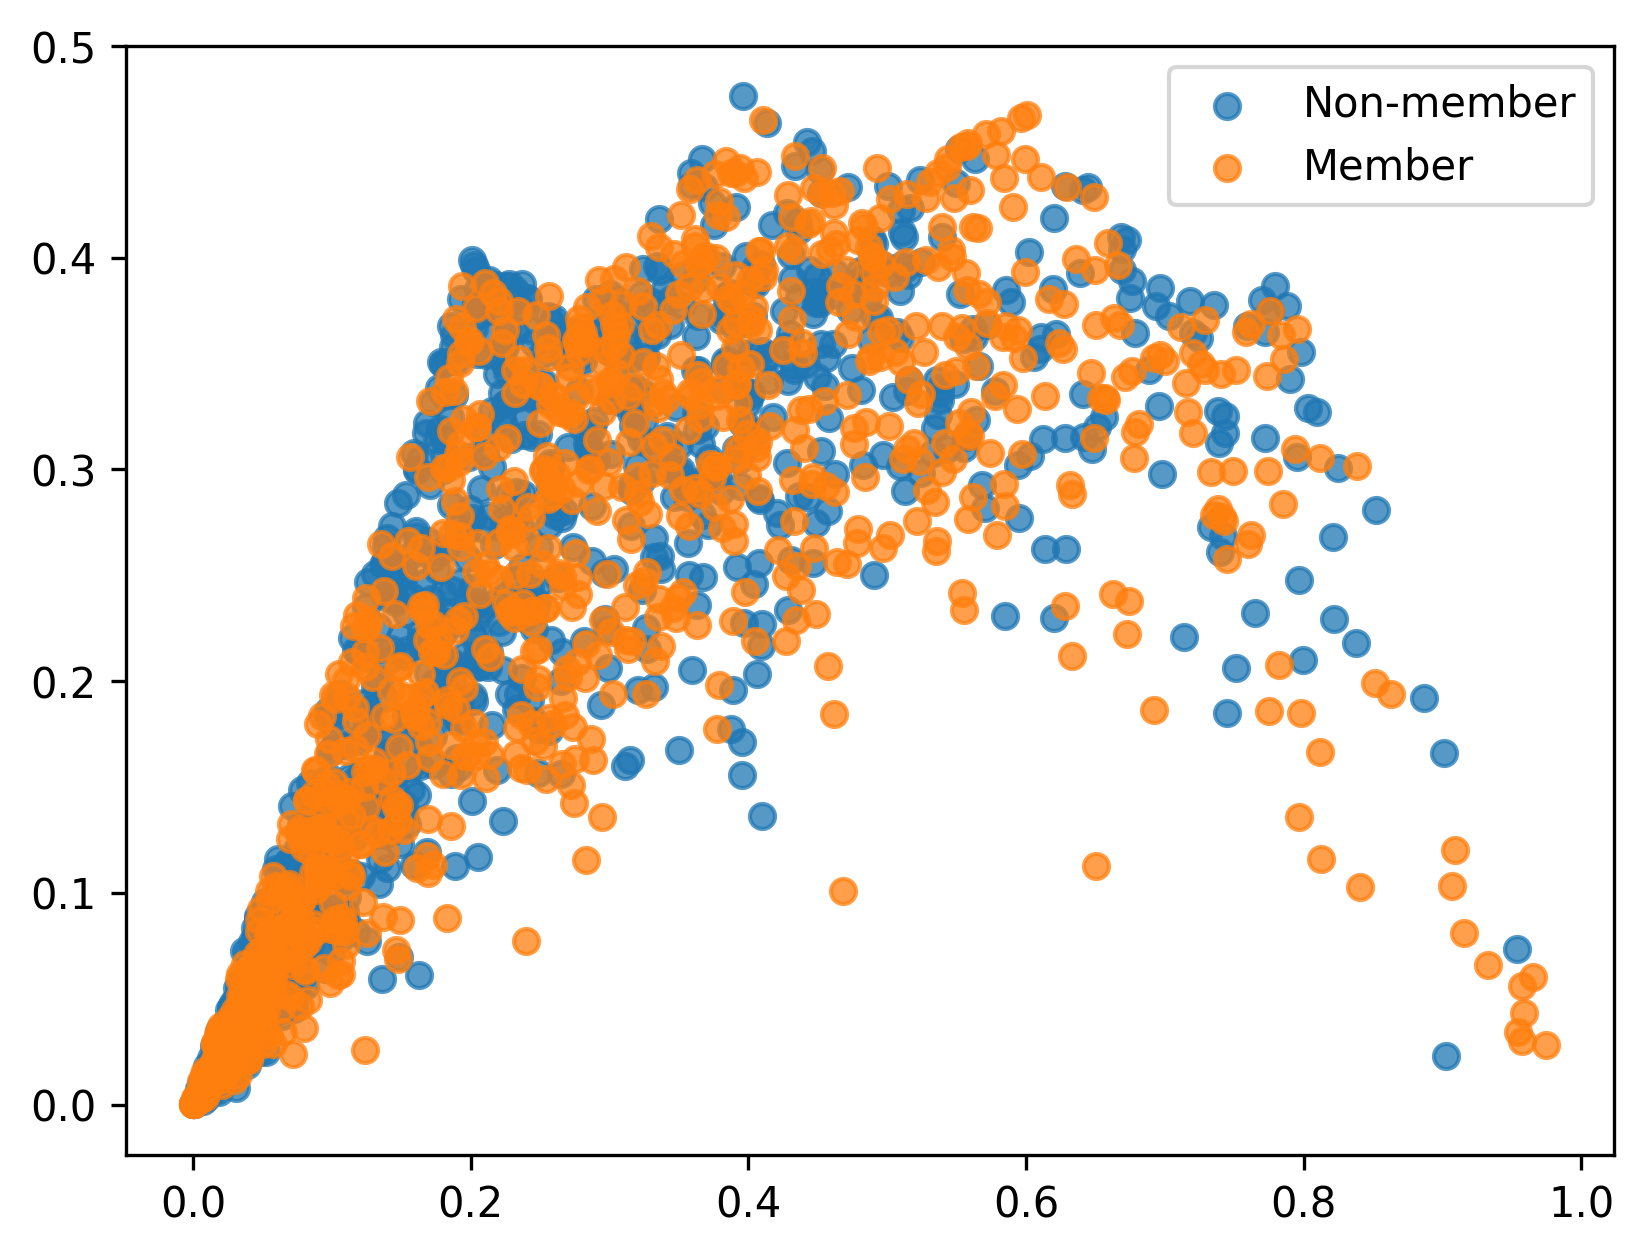

In [135]:
meanie = lambda x: np.mean(x, 1)
# rangie = lambda x: np.max(x, 1) - np.min(x, 1)
rangie = lambda x: np.std(x, 1)

plt.scatter(meanie(nonmem), rangie(nonmem), label="Non-member", color="C0", alpha=0.75)
plt.scatter(meanie(mem), rangie(mem), label="Member", color="C1", alpha=0.75)
plt.legend()

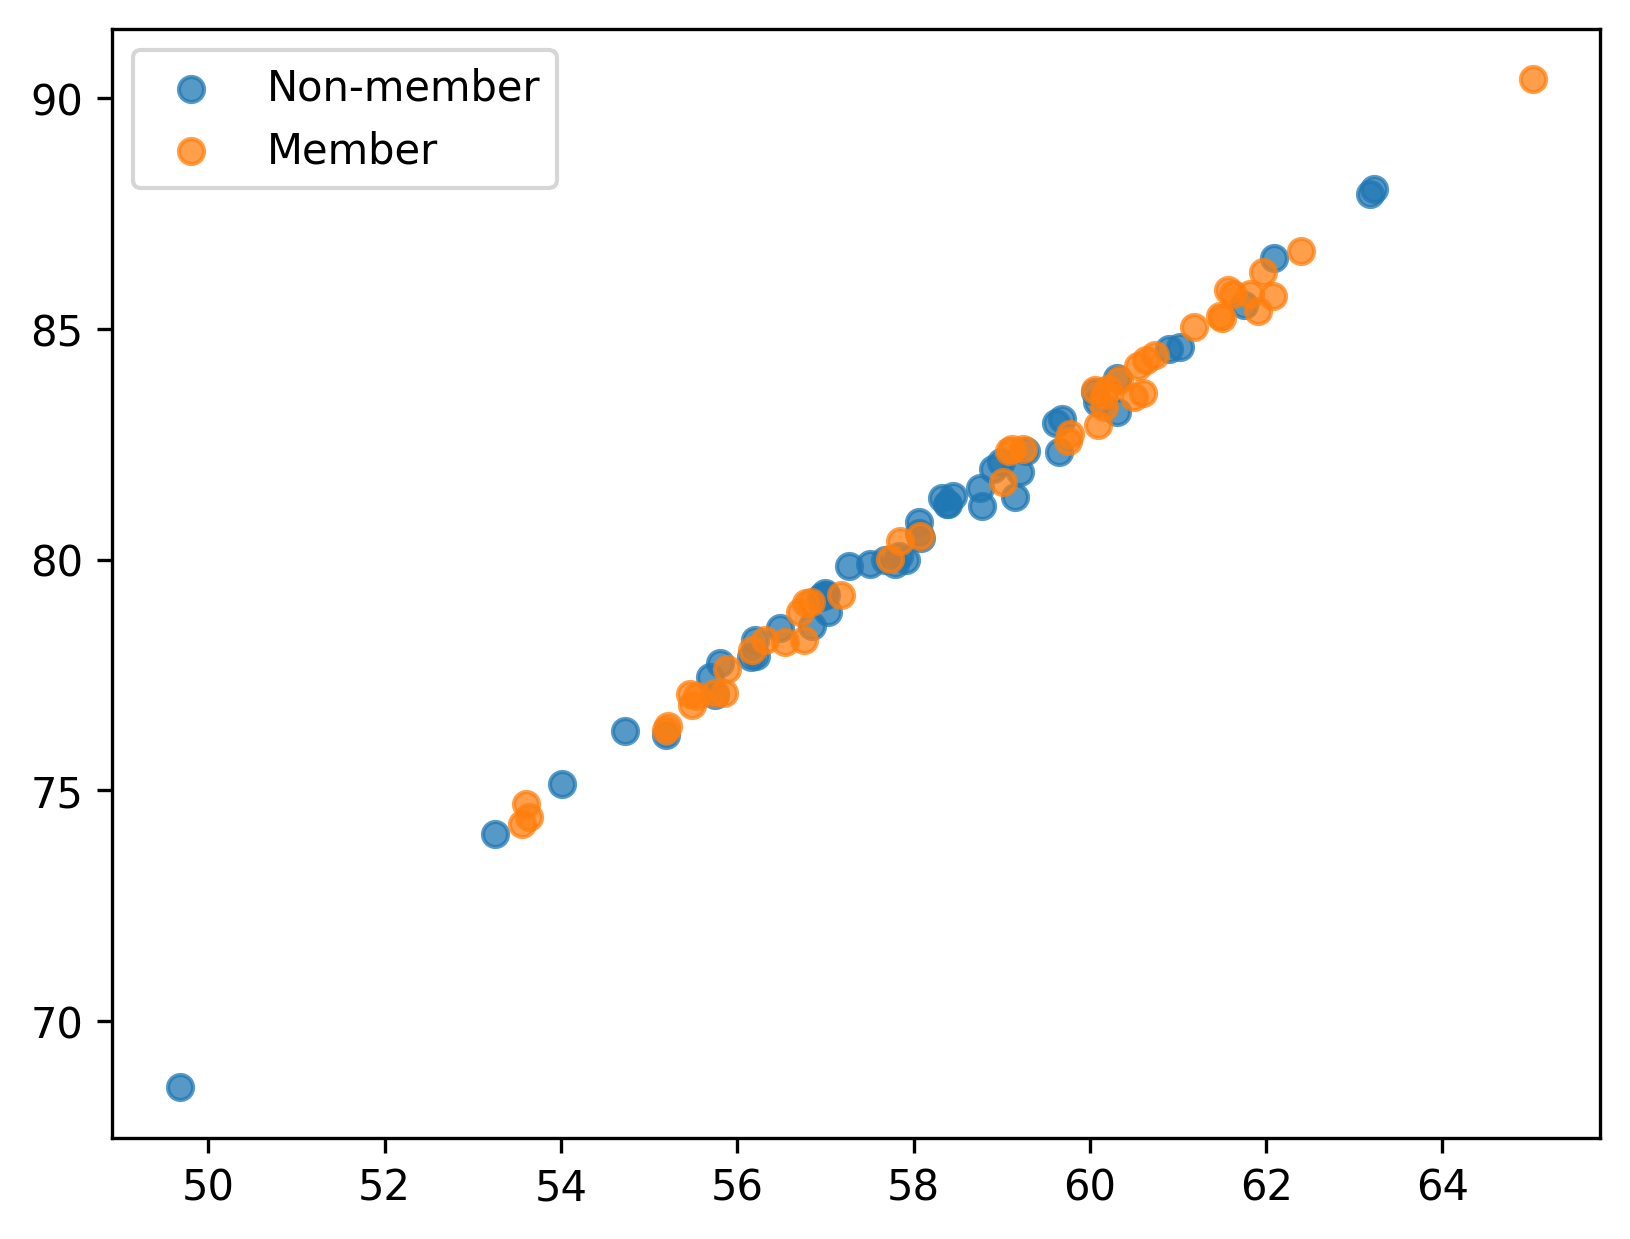

In [122]:
picked = (0, 1)
plt.scatter(nonmem[:, picked[0]], nonmem[:, picked[1]], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[:, picked[0]], mem[:, picked[1]], label="Member", color="C1", alpha=0.75)
plt.legend()

(3, 2)


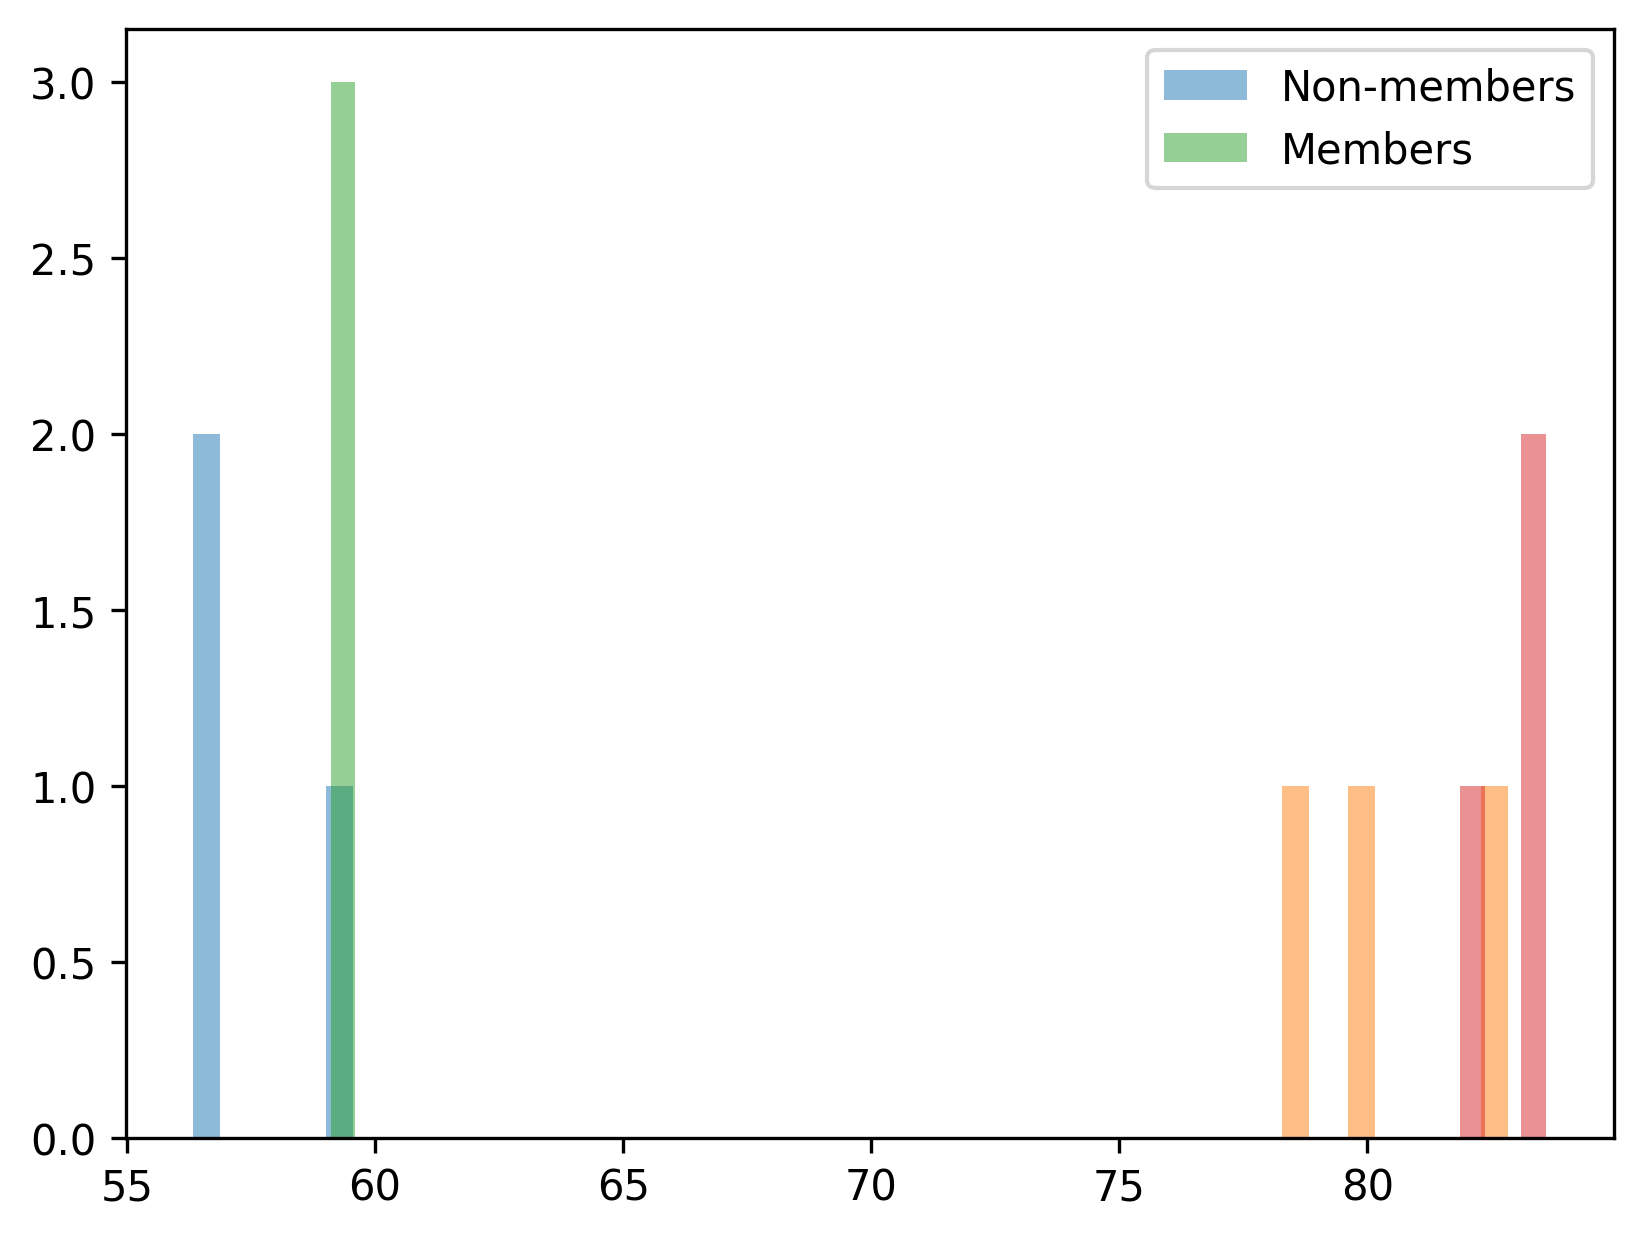

In [119]:
plt.hist(nonmem, bins=20, alpha=0.5, label="Non-members")
plt.hist(mem, bins=20, alpha=0.5, label="Members")
plt.legend()

In [44]:
nonmem

array([[53.350304, 74.051636],
       [54.732616, 76.10981 ],
       [52.65871 , 73.23374 ],
       [51.415714, 71.43139 ],
       [54.366547, 75.306274],
       [53.52079 , 74.45516 ],
       [53.612556, 74.00986 ],
       [50.4199  , 69.37543 ],
       [51.614155, 71.65016 ],
       [55.111057, 76.573524],
       [54.77948 , 76.09276 ],
       [49.942   , 69.14336 ],
       [51.78936 , 72.04028 ],
       [51.818413, 72.169586],
       [52.811924, 72.90627 ],
       [50.28319 , 69.44859 ],
       [47.99787 , 66.71631 ],
       [53.60613 , 74.55159 ],
       [53.33048 , 74.13255 ],
       [51.47933 , 71.70819 ],
       [53.439087, 74.2416  ],
       [55.1475  , 76.72871 ],
       [48.671177, 67.068375],
       [53.730633, 74.235275],
       [50.361374, 69.615425],
       [51.50388 , 71.65975 ],
       [54.80468 , 76.12955 ],
       [50.89718 , 70.76041 ],
       [51.614136, 71.55613 ],
       [51.589912, 71.25009 ],
       [54.06504 , 75.194466],
       [51.171032, 71.171265],
       [

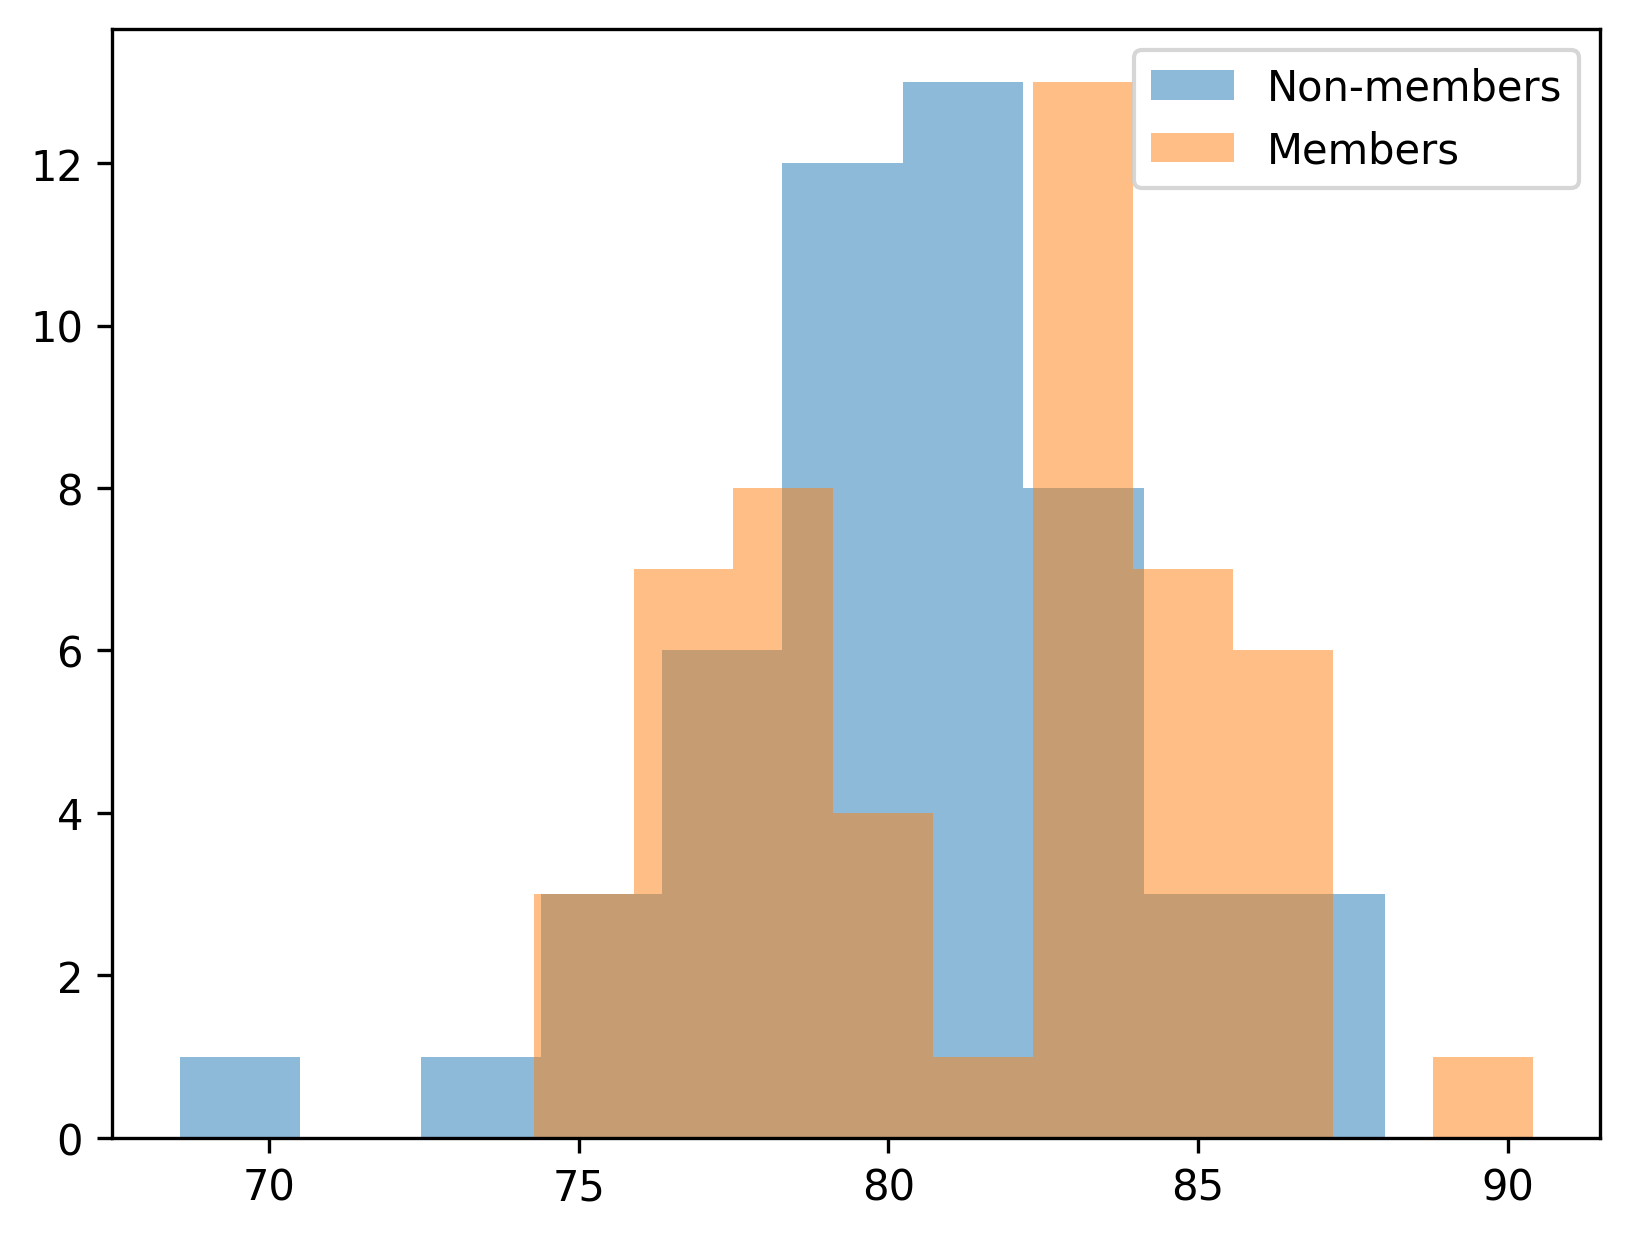

In [127]:
plt.hist(nonmem[:, 1], bins=10, alpha=0.5, label="Non-members")
plt.hist(mem[:, 1], bins=10, alpha=0.5, label="Members")
plt.legend()